The data from this exercise comes from the UCI Machine Learning Repository: https://archive.ics.uci.edu/ml/datasets/Car+Evaluation For more details on the data set see the included documentation.

In [1]:
# Ensure that Aequitas dependency is installed
!pip install aequitas==0.42 sklearn -q

You should consider upgrading via the '/opt/app-root/bin/python3.8 -m pip install --upgrade pip' command.


In [2]:
# Imports
from aequitas.plotting import Plot
ap = Plot()
import pandas as pd
import seaborn as sns

from aequitas.group import Group
from aequitas.bias import Bias 
from aequitas.fairness import Fairness

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, label_binarize, LabelBinarizer
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
# I manually added the headers to the data set.
df = pd.read_csv("data/car.csv")

# We'll modify the data to make it a binary problem of acceptable or unacceptable car.
df = df.where(df != 'good', 'acc')
df = df.where(df != 'vgood', 'acc')

df = df.rename(columns={'car': 'score'})

# BK
df_score = df

# Save the car column in the y dataframe.
y = df.pop('score')

# Save the remaining columns in the X dataframe.
X = df

print(df_score.head())

# df['safety']

  buying  maint doors persons lug_boot safety
0  vhigh  vhigh     2       2    small    low
1  vhigh  vhigh     2       2    small    med
2  vhigh  vhigh     2       2    small   high
3  vhigh  vhigh     2       2      med    low
4  vhigh  vhigh     2       2      med    med


In [4]:
df['buying'].value_counts()

vhigh    432
high     432
med      432
low      432
Name: buying, dtype: int64

In [5]:
X['safety'].value_counts()

low     576
med     576
high    576
Name: safety, dtype: int64

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=23)
print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)

# Use this later to construct the DataFrame Aequitas requires.
df_aq = X_test.copy()

ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)
X_train = ohe.fit_transform(X_train.values)
X_test = ohe.transform(X_test.values)

lb = LabelBinarizer()
y_train = label_binarize(y_train.values, classes=['unacc', 'acc']).ravel()
y_test = label_binarize(y_test.values, classes=['unacc', 'acc']).ravel()

X_train shape:  (1296, 6)
X_test shape:  (432, 6)


In [7]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

scores = lr.predict_proba(X_test)
pred = lr.predict(X_test)

f1 = f1_score(y_test, pred)
print(f"F1 score: {f1:.4f}")

F1 score: 0.8960


In [8]:
# Construct the dataframe that Aequitas will use.
# You can draw inspiration from examples present here: https://github.com/dssg/aequitas/blob/master/docs/source/examples/compas_demo.ipynb 

In [9]:
by_safety = df_aq[df_aq.safety.isin(['low', 'med', 'high'])]

In [15]:
aq_palette = sns.diverging_palette(100, 200, n=4)
aq_palette = sns.crayon_palette(["Red","Green","Blue","Salmon"])

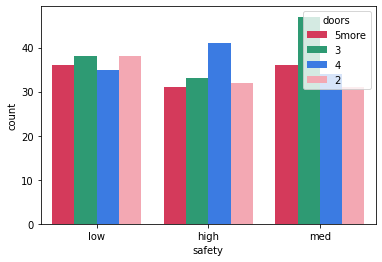

In [16]:
by_doors = sns.countplot(x="safety", hue="doors", data=by_safety, palette=aq_palette)


In [12]:
# Run Aequitas.
# Summarize: Aequitas classes provides a few functions that provide a high level summary of fairness and disparity, such as 
# plot_fairness_group_all()
# plot_fairness_disparity_all()
# plot_disparity_all()


In [13]:
df_aq.columns
df_aq['score'] = y_test
df_aq['label_value'] = y_test

In [14]:
group = Group()
xtab, _ = group.get_crosstabs(df_aq)
xtab.head()

,model_id,score_threshold,k,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,pp,pn,ppr,pprev,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities,prev
0,0,binary 0/1,119,buying,high,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,23,90,0.193277,0.203540,0,0,90,23,23,90,113,432,0.203540
1,0,binary 0/1,119,buying,low,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,37,55,0.310924,0.402174,0,0,55,37,37,55,92,432,0.402174
2,0,binary 0/1,119,buying,med,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,41,75,0.344538,0.353448,0,0,75,41,41,75,116,432,0.353448
3,0,binary 0/1,119,buying,vhigh,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,18,93,0.151261,0.162162,0,0,93,18,18,93,111,432,0.162162
4,0,binary 0/1,119,maint,high,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,29,85,0.243697,0.254386,0,0,85,29,29,85,114,432,0.254386
